<center><h2>ALTeGraD 2023<br>Lab Session 1: NMT</h2><h3> Neural Machine Translation</h3> 10 / 10 / 2023<br> Dr. G. Shang and H. Abdine</center>


## Student: Balthazar Neveu
Email: balthazar.neveu@ens-paris-saclay.fr

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from typing import Tuple, Union, List
import logging
import json
import matplotlib.pyplot as plt
from pathlib import Path

path_to_data = Path('./data')
path_to_save_models = Path('./models')

[nltk_data] Downloading package punkt to /home/bneveu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Define the Encoder / Task 1

`L, N, H` mean batch_first = False
- First dimension is the sequence length `L`
- Second dimension, `N = batch size`
- Last dimension: `feature dimension`:
    - `H_in` : embedding dimension
    - `H_out`: hidden feature size = encoder output feature size.

In [3]:
class Encoder(nn.Module):
    '''
    source_sentence (int) [L, N] in source language
    -> encoded_sentence [L, N, H_out], hidden_state [1, N, H_out]

    Transforms a source input sentence [L, N] into float embeddings [L, N, H_in]
    Then pass into a (unidirectional non stacked) RNN based on the GRU design.
    
    Tokens are not passed one by one.
    The whole module treats a batch of sentences as a vector.

    >>> Encoded sentence = hidden states sequence
    hidden_start = last element on the encoded sentence
    '''
    def __init__(self,
                 vocab_size_source: int,
                 embedding_dim: int, # H_in
                 hidden_dim: int, # H_out
                 padding_idx: int
        ):
        
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size_source, embedding_dim, padding_idx) # source language embeddings
        # we use padding_idx in nn.Embedding
        # so that the padding vector does not take gradient (always zero)
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(
            self,
            source_sentence: Union[torch.IntTensor, torch.LongTensor]
        ) -> torch.FloatTensor:
        """
        int [L, N] -> [L, N, H_out], [1, N, H_out]
        """
        # input_sentence: long/int [L, N]  -> embedding -> embeddings: float [L, N, H_in]
        embeddings = self.embedding(source_sentence) # [L, N, H_in]
        
        # embeddings: [L, N, H_in], hidden_init -> GRU -> encoded sentence [L, N, H_out], hidden_state [1, N, H_out]
        encoded, _hidden_state = self.rnn(embeddings) # [L, N, H_out], [1, N, H_out]
        return encoded

In [4]:
# Source language definitions
L = 32         # sentence length
N = 4          # batch_size
vocab_size_source = 256

# Encoder
H_in = 16      # Embdedding size
H_out_src = 32 # Hidden state size in the encoder


# Decoder
H_out_tgt = 32 # Hidden state size in the decoder
# WARNING: For the attention mechanism to work properly, we need H_out_src=H_out_tgt
L_target = 1
vocabulary_size_target = 73

# Attention
H_attention = 28 # we can have any H here.
# But for the decoder to work, we'll need to have H_out_src==H_out_tgt

assert H_out_src==H_out_tgt

In [5]:
def test_encoder():
    source_sentence = torch.randint(4, vocab_size_source, (L, N), dtype=torch.long)
    co = Encoder(vocab_size_source, H_in, H_out_src, padding_idx=0)
    encoded_sentence = co(source_sentence)
    assert encoded_sentence.shape == (L, N, H_out_src), f"{encoded_sentence.shape}"
    # assert hidden_state.shape == (1, N, H_out_src), f"{hidden_state.shape}"
    # assert encoded_sentence[-1, ...].allclose(hidden_state[0, ...]), f"{encoded_sentence[-1, 0, :]} != {hidden_state[0, 0, :]}"
    return encoded_sentence 
encoded_sentence = test_encoder()
# Note : last element of the encoded_sentence = hidden_state ... output of the GRU is basically the vector made of all hidden_states...

## Define the Attention layer / Task 3

In [6]:
class Seq2seqAtt(nn.Module):
    '''
    concat global attention a la Luong et al. 2015 (subsection 3.1)
    Pick the concat strategy (not the dot product usually used in transformers.)
    https://arxiv.org/pdf/1508.04025.pdf
    '''
    def __init__(
            self,
            hidden_dim,   # H
            hidden_dim_s, # H_out_src
            hidden_dim_t  # H_out_target
        ):
        super(Seq2seqAtt, self).__init__()
        self.ff_concat = nn.Linear(hidden_dim_s+hidden_dim_t, hidden_dim)
        self.ff_score = nn.Linear(hidden_dim, 1, bias=False) # just a dot product here
        if hidden_dim_s!=hidden_dim_t:
            logging.warning(f"{hidden_dim_s=} differs from {hidden_dim_t=} - this will not allow the decoder to work properly!")

    def forward(self,
                target_h: torch.FloatTensor, # [1, N, H_out_target]
                source_hs: torch.FloatTensor, # [L, N, H_out_source]
                return_scores: bool =False
                ) -> torch.FloatTensor: #  [1, N, H_out_source] ([L, N] if return_scores)
        """Global attention based on the concatenation strategy
        
        return_scores: if True, will return normed scores of size  [L, N]

        
        Description
        -----------
        A single target vector <target_h> is compared to all source embeddings <source_hs> [L, N, H_out_source]
        - A score is computed [L, N] to know which of the L vectors 
        the current word shall attend to.
        - The weighted sum with the source values allows to provide 
        the most relevant word(s) context in the source (hidden) space.
        - The returned tensor of size  [1, N, H_out_source] gives a (single) representation 
        of the source context which matches the current target token.

        
        """
        
        target_h_rep = target_h.repeat(source_hs.size(0), 1, 1) # [1, N, H_out_t] -> [L, N, H_out_t] # (1, batch, feat) -> (seq, batch, feat)
        
        # Score computation part of the concat formulation (see section 3.1. of Luong 2015)
        concat_output = torch.concat((target_h_rep, source_hs), dim=-1) # -> [L, N, H_out_target, H_out_src]
        scores = self.ff_concat(concat_output) # [L, N, H_out_target, H_out_src] -> [L, N, H]
        scores = torch.tanh(scores) # [L, N, H]
        scores =self.ff_score(scores) # [L, N, H] -> [L, N, 1] dot product
        assert scores.shape[-1] == 1
        scores = scores.squeeze(dim=-1) # [L, N] squeeze the last single dimension     # (seq, batch, 1) -> (seq, batch). dim = 2 because we don't want to squeeze the batch dim if batch size = 1
        
        
        norm_scores = torch.softmax(scores, dim=0) # [L, N] # softmax across the whole sequence (dim=0 , L floats)
        if return_scores:
            return norm_scores  # Bypass the end of the computation and return normed attention scores
        source_hs_p = source_hs.permute((2, 0, 1)) # -> [H_out_source, L, N] # (seq, batch, feat) -> (feat, seq, batch)

        # attention_weights * value # element wise product [L, N] [H_out_source, L, N] -> [H_out_source, L, N]
        weighted_source_hs = (norm_scores * source_hs_p) # (seq, batch) * (feat, seq, batch) (* checks from right to left that the dimensions match)
        
        context = torch.sum(weighted_source_hs.permute((1, 2, 0)), 0, keepdim=True) # [H_out_source, L, N] -> [L, N, H_out_source] -> [1, N, H_out_source]
        # (feat, seq, batch) -> (seq, batch, feat) -> (1, batch, feat); keepdim otherwise sum squeezes
        return context


In [7]:
def test_seq2seqAtt():
    target_hidden_state = torch.rand((1, N, H_out_tgt))
    encoded_sentence == torch.rand(L, N, H_out_src)
    attention_module = Seq2seqAtt(H_attention, H_out_src, H_out_tgt)
    ct = attention_module(target_hidden_state, encoded_sentence)
    assert ct.shape == (1, N, H_out_src)

test_seq2seqAtt()

## Define the Decoder layer / Task 2

In [8]:
class Decoder(nn.Module):
    '''
    to be used one timestep at a time
       see https://pytorch.org/docs/stable/nn.html#gru'''
    def __init__(self,
                 vocab_size_target: int,
                 embedding_dim: int,  # H_in
                 hidden_dim: int, # H_out
                 padding_idx: int
        ):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size_target, embedding_dim, padding_idx) # target language embeddings
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.ff_concat = nn.Linear(2*hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, vocab_size_target)

    def forward(self,
                target_sentence: torch.IntTensor,        # [L=1, N, H_in] int/long
                source_context: torch.FloatTensor,       # [1  , N, H_out]
                previous_hidden_state: torch.FloatTensor # [1  , N, H_out]
                ) -> Tuple[torch.FloatTensor, torch.FloatTensor]: # [L=1, N, vocab_size_target], [1, N, H_out]
        """target_sentence, source_context, previous_hidden_state"""
        # Note: when predicting word by word, we simply use L=1

        # transform input into embeddings, pass embeddings to RNN, concatenate with source_context and apply tanh, and make the prediction
        # prediction should be of shape (1, batch, vocab), h and tilde_h of shape (1, batch, feat)
        embeddings = self.embedding(target_sentence) # [L=1, N, H_in]
        _decoded, updated_hidden_state = self.rnn(embeddings, previous_hidden_state) # -> [L=1, N, H_out],  [1, N, H_out]
        attentional_hidden_state = torch.concat([source_context, updated_hidden_state], dim=-1) # -> [L=1, N, 2*H_out]
        
        # linear "squeeze" of the concanated hidden state & context [L=1, N, 2*H_out] -> [L=1, N, H_out]
        attentional_hidden_state = self.ff_concat(attentional_hidden_state)
        attentional_hidden_state = torch.tanh(attentional_hidden_state) # [L=1, N, H_out] in the range [-1, 1]
        
        # W_s. h~ -> not probabilities yet, we'll apply softmax later
        prediction_logits = self.predict(attentional_hidden_state) # [L=1, N, H_out] -> [L=1, N, vocab_size_target]
        # prediction = torch.softmax(prediction, dim=-1)
        return prediction_logits, updated_hidden_state

In [9]:
def test_decoder() -> torch.FloatTensor:
    """Test example on a full inference pipeline"""
    target_sentence = torch.randint(4, vocabulary_size_target, (L_target, N), dtype=torch.long)
    source_context = torch.rand((L_target, N, H_out_src))
    hidden_state = torch.rand((1, N, H_out_tgt))
    dec = Decoder(vocabulary_size_target, H_in, H_out_tgt, padding_idx=0)
    decoded_prediction_logits, hidden_state = dec(target_sentence, source_context, hidden_state)
    assert decoded_prediction_logits.shape == (L_target, N, vocabulary_size_target), f"{decoded_prediction_logits.shape}"
    assert hidden_state.shape == (1, N, H_out_tgt), f"{hidden_state.shape}"
    decoded_prediction_probabilities = torch.softmax(decoded_prediction_logits, dim=-1)
    assert (torch.sum(decoded_prediction_probabilities, dim=-1)).isclose(torch.ones(1, N)).all() # assert logits turned to probabilities sum to 1
    return hidden_state
target_hidden_state = test_decoder()

In [10]:
def test_inference_pipeline():
    """Test example on a full inference pipeline"""
    SOS_TOKEN, EOS_TOKEN = 2, 3
    source_sentence = torch.randint(4, vocab_size_source, (L, N), dtype=torch.long)
    co = Encoder(vocab_size_source, H_in, H_out_src, padding_idx=0)
    attention_module = Seq2seqAtt(H_attention, H_out_src, H_out_tgt)
    dec = Decoder(vocabulary_size_target, H_in, H_out_tgt, padding_idx=0)
    
    
    encoded_sentence = co(source_sentence)
    target_token = SOS_TOKEN*torch.ones((L_target, N), dtype=torch.long)
    target_hidden_state = torch.zeros((1, N, H_out_tgt))
    # while target_token!=EOS_TOKEN:
    # for _idx in range(L):
    translated = [[] for _ in range(N)]
    for _idx in range(30):
        source_context = attention_module(target_hidden_state, encoded_sentence)
        decoded_prediction, target_hidden_state = dec(target_token, source_context, target_hidden_state)
        target_token = torch.argmax(decoded_prediction, dim=-1) # Sample the most likely token
        assert target_token.shape == (L_target, N)
        for batch_element in range(target_token.shape[1]):
            current_token = int(target_token[:, batch_element])
            if current_token==EOS_TOKEN:
                print(f"End of sentence reached {_idx}")
                continue
            translated[batch_element].append(current_token)
    # print(translated)
test_inference_pipeline()

# Define the full seq2seq model / Task 4:

## Special random sampling (temperature based)

In [ ]:
def random_word_sampling(
        logits: torch.FloatTensor, # [L, N, vocabulary_size]
        temperature:float=1.
    ) -> torch.LongTensor: # int [L, N]
    """Sample from a logit distribution based on a temperature
    If temperature = 0, this is equivalent to argmax
    If temperature goes to infinity, this is equivalent to sampling randomly
    """
    scaled_logits = logits / temperature
    # Convert logits to probabilities
    probabilities = torch.softmax(scaled_logits, dim=-1)
    # Sample from the probabilities
    probabilities = probabilities.view(-1, probabilities.shape[-1])
    flattened_indexes= torch.multinomial(probabilities, 1).squeeze()
    indexes = flattened_indexes.view(logits.shape[0], logits.shape[1])
    return indexes

def test_random_sampling():
    logits = torch.rand(2, N, vocabulary_size_target)
    logits.shape
    samples = random_word_sampling(logits, temperature=1.E-19)
    assert(samples.allclose(torch.argmax(logits, dim=-1)))
test_random_sampling()


In [59]:
class seq2seqModel(nn.Module):
    '''the full seq2seq model'''
    ARGS = ['vocab_s','source_language','vocab_t_inv','embedding_dim_s','embedding_dim_t',
     'hidden_dim_s','hidden_dim_t','hidden_dim_att','do_att','padding_token',
     'oov_token','sos_token','eos_token','max_size']
    def __init__(self, vocab_s, source_language, vocab_t_inv, embedding_dim_s, embedding_dim_t,
                 hidden_dim_s, hidden_dim_t, hidden_dim_att, do_att, padding_token,
                 oov_token, sos_token, eos_token, max_size):
        super(seq2seqModel, self).__init__()
        self.vocab_s = vocab_s
        self.source_language = source_language
        self.vocab_t_inv = vocab_t_inv
        self.embedding_dim_s = embedding_dim_s
        self.embedding_dim_t = embedding_dim_t
        self.hidden_dim_s = hidden_dim_s
        self.hidden_dim_t = hidden_dim_t
        self.hidden_dim_att = hidden_dim_att
        self.do_att = do_att # should attention be used?
        self.padding_token = padding_token
        self.oov_token = oov_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.max_size = max_size

        self.max_source_idx = max(list(vocab_s.values()))
        print('max source index',self.max_source_idx)
        print('source vocab size',len(vocab_s))

        self.max_target_idx = max([int(elt) for elt in list(vocab_t_inv.keys())])
        print('max target index',self.max_target_idx)
        print('target vocab size',len(vocab_t_inv))
        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device("cuda")
        self.encoder = Encoder(self.max_source_idx+1, self.embedding_dim_s, self.hidden_dim_s, self.padding_token).to(self.device)
        self.decoder = Decoder(self.max_target_idx+1, self.embedding_dim_t, self.hidden_dim_t, self.padding_token).to(self.device)

        if self.do_att:
            self.att_mech = Seq2seqAtt(self.hidden_dim_att, self.hidden_dim_s, self.hidden_dim_t).to(self.device)
        
        self.debug_dict = {}

    def my_pad(self, my_list):
        '''my_list is a list of tuples of the form [(tensor_s_1, tensor_t_1), ..., (tensor_s_batch, tensor_t_batch)]
        the <eos> token is appended to each sequence before padding
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_sequence'''
        batch_source = pad_sequence([torch.cat((elt[0], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        batch_target = pad_sequence([torch.cat((elt[1], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        return batch_source, batch_target

    def forward(self, input, max_size, is_prod, temperature=0):
        if is_prod:
            input = input.unsqueeze(1) # (seq) -> (seq, 1) 1D input <=> we receive just one sentence as input (predict/production mode)
            self.debug_dict["attention"] = []
        current_batch_size = input.size(1)

        # encode the whole input sequence at one.
        source_hs = self.encoder(input) 
        # = = = decoder part (one timestep at a time)  = = =
        target_h = torch.zeros(size=(1, current_batch_size, self.hidden_dim_t)).to(self.device) # [1, N, H_out_target] # init (1, batch, feat)
        # NOTE: the initial target_h hidden state is not trainable, it is set to 0. 

        # (initialize target_input with the proper Start of Sentense <SOS> token)
        target_input = torch.LongTensor([self.sos_token]).repeat(current_batch_size).unsqueeze(0).to(self.device) # int [1, N] init (1, batch)
        pos = 0
        eos_counter = 0
        logits = []
        
        while True:
            if self.do_att:
                source_context = self.att_mech(target_h, source_hs) # [1, N, H]  (1, batch, feat)
                if is_prod:
                    # score has size [L, N].
                    # When pos==0,  target_h=0 ... 
                    # When pos==1,we'll get the attention score of the first translated word
                    self.debug_dict["attention"].append(self.att_mech(target_h, source_hs, return_scores=True)) # [L, N]
            else:
                source_context = source_hs[-1, :, :].unsqueeze(0) # (1, batch, feat) last hidden state of encoder
            
            # use the decoder
            prediction, target_h = self.decoder(target_input, source_context, target_h) #int [1, N], [1, N, H], [1, N, H] ->  [1, N, vocab_size_target], [1, N, H]
            logits.append(prediction) # (1, batch, vocab)
            # get the next input to pass the decoder - GREEDY DECODING
            if temperature ==0 or not is_prod:
                target_input = torch.argmax(prediction, dim=-1) # the predicted word
            else:
                target_input = random_word_sampling(prediction, temperature)
                
            eos_counter += torch.sum(target_input==self.eos_token).item()
            pos += 1
            if pos >= max_size or (eos_counter == current_batch_size and is_prod):
                break
        to_return = torch.cat(logits, 0) # logits is a list of tensors -> (seq, batch, vocab)

        if is_prod:
            to_return = to_return.squeeze(dim=1) # (seq, vocab)

        return to_return

    # -------------------- Training loop... as part of the model--------------------------------------------------
    def fit(self, trainingDataset, testDataset, lr, batch_size, n_epochs, patience):
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = optim.Adam(parameters, lr=lr)
        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.padding_token) # the softmax is inside the loss!
        # https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        # we pass a collate function to perform padding on the fly, within each batch
        # this is better than truncation/padding at the dataset level
        train_loader = data.DataLoader(trainingDataset, batch_size=batch_size,
                                       shuffle=True, collate_fn=self.my_pad) # returns (batch, seq)
        test_loader = data.DataLoader(
            testDataset,
            batch_size=128, # required to fit on T500 GPU
            # batch_size=512,
            collate_fn=self.my_pad
        )
        
        metric_logger = self.get_metrics()
        n_start = len(metric_logger["training_loss"])
        tdqm_dict_keys = ['loss', 'test loss']
        tdqm_dict = dict(zip(tdqm_dict_keys, [0.0, 0.0]))
        patience_counter = 1
        patience_loss = 99999
        
        for epoch in range(n_start, n_epochs):
            with tqdm(total=len(train_loader), unit_scale=True, postfix={'loss':0.0, 'test loss':0.0},
                      desc="Epoch : %i/%i" % (epoch, n_epochs-1), ncols=100) as pbar:
                for loader_idx, loader in enumerate([train_loader, test_loader]):
                    total_loss = 0
                    total_elements = 0
                    # set model mode (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
                    if loader_idx == 0:
                        self.train()
                    else:
                        self.eval()
                    for i, (batch_source, batch_target) in enumerate(loader):
                        # if i>20: continue; # For quick testing
                        batch_source = batch_source.transpose(1, 0).to(self.device) # RNN needs (seq, batch, feat) but loader returns (batch, seq)
                        batch_target = batch_target.transpose(1, 0).to(self.device) # (seq, batch)

                        # are we using the model in production
                        is_prod = len(batch_source.shape)==1 # if False, 2D input (seq, batch), i.e., train or test
                        if is_prod:
                            max_size = self.max_size
                            self.eval()
                        else:
                            max_size = batch_target.size(0) # no need to continue generating after we've exceeded the length of the longest ground truth sequence

                        unnormalized_logits = self.forward(batch_source, max_size, is_prod)
                        sentence_loss = criterion(unnormalized_logits.flatten(end_dim=1), batch_target.flatten())
                        total_loss += sentence_loss.item()
                        total_elements+= 1
                        tdqm_dict[tdqm_dict_keys[loader_idx]] = total_loss/total_elements
                        pbar.set_postfix(tdqm_dict)
                        if loader_idx == 0: # (Training time)
                            optimizer.zero_grad() # flush gradient attributes
                            sentence_loss.backward() # compute gradients
                            optimizer.step() # update
                            pbar.update(1)
                    metric_logger["training_loss" if loader_idx==0 else "test_loss"].append(total_loss/total_elements)
            self.save_metric_logs(metric_logger, "metric.json")
            self.save(f'checkpoint_{epoch=}.pt')
            if total_loss > patience_loss:
                patience_counter += 1
            else:
                patience_loss = total_loss
                patience_counter = 1 # reset

            if patience_counter > patience:
                break

    # -------------------- NL <-> ints ------------------------------------------------------
    def sourceNL_to_tokens(self, source_nl):
        source_nl_clean = source_nl.lower().replace("'",' ').replace('-',' ')
        source_nl_clean_tok = word_tokenize(source_nl_clean, self.source_language)
        return source_nl_clean_tok

    def sourceNl_to_ints(self, source_nl):
        '''converts natural language source sentence into source integers'''
        source_nl_clean_tok = self.sourceNL_to_tokens(source_nl)
        source_ints = [int(self.vocab_s[elt]) if elt in self.vocab_s else \
                       self.oov_token for elt in source_nl_clean_tok]

        source_ints = torch.LongTensor(source_ints).to(self.device)
        return source_ints

    def targetInts_to_nl(self, target_ints):
        '''converts integer target sentence into target natural language'''
        return ['<PAD>' if elt==self.padding_token else '<OOV>' if elt==self.oov_token \
                else '<EOS>' if elt==self.eos_token else '<SOS>' if elt==self.sos_token\
                else self.vocab_t_inv[elt] for elt in target_ints]
    
    def predict(self, source_nl, return_list=False, temperature=0.):
        source_ints = self.sourceNl_to_ints(source_nl)
        logits = self.forward(source_ints, self.max_size, True, temperature=temperature) # (seq) -> (<=max_size, vocab)
        target_ints = logits.argmax(-1).squeeze() # (<=max_size, 1) -> (<=max_size)
        target_nl = self.targetInts_to_nl(target_ints.tolist())
        return target_nl if return_list else ' '.join(target_nl)
    
    
    # -------------------- Utilities (save, load, dump metrics) -----------------------------
    def save(self, path_to_file):
        attrs = {attr:getattr(self,attr) for attr in self.ARGS}
        attrs['state_dict'] = self.state_dict()
        torch.save(attrs, path_to_file)
    
    def save_metric_logs(self, metric_logger, path_to_file):
        with open(path_to_file, 'w') as f:
            json.dump(metric_logger, f)
    
    @classmethod # a class method does not see the inside of the class (a static method does not take self as first argument)
    def load(cls, path_to_file):
        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage) # allows loading on CPU a model trained on GPU, see https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/6
        state_dict = attrs.pop('state_dict')
        new = cls(**attrs) # * list and ** names (dict) see args and kwargs
        new.load_state_dict(state_dict)
        return new
    @staticmethod
    def get_metrics():
        if Path("metric.json").exists():
            with open("metric.json", "r") as fi:
                metrics = json.load(fi)
            return metrics
        else:
            return {"training_loss": [], "test_loss": []}


## Prepare the Data:

In [13]:
class Dataset(data.Dataset):
  def __init__(self, pairs):
        self.pairs = pairs

  def __len__(self):
        return len(self.pairs) # total nb of observations

  def __getitem__(self, idx):
        source, target = self.pairs[idx] # one observation
        return torch.LongTensor(source), torch.LongTensor(target)

def load_pairs(train_or_test):
    with open(path_to_data / ('pairs_' + train_or_test + '_ints.txt'), 'r', encoding='utf-8') as file:
        pairs_tmp = file.read().splitlines()
    pairs_tmp = [elt.split('\t') for elt in pairs_tmp]
    pairs_tmp = [[[int(eltt) for eltt in elt[0].split()],[int(eltt) for eltt in \
                  elt[1].split()]] for elt in pairs_tmp]
    return pairs_tmp

## Training / Task 5:

In [60]:
do_att = True # should always be set to True
is_prod = False # production mode or not

if not is_prod:

    pairs_train = load_pairs('train')
    pairs_test = load_pairs('test')

    with open(path_to_data / 'vocab_source.json','r') as file:
        vocab_source = json.load(file) # word -> index

    with open(path_to_data / 'vocab_target.json','r') as file:
        vocab_target = json.load(file) # word -> index

    vocab_target_inv = {v:k for k,v in vocab_target.items()} # index -> word

    print('data loaded')

    training_set = Dataset(pairs_train)
    test_set = Dataset(pairs_test)

    print('data prepared')

    print('= = = attention-based model?:',str(do_att),'= = =')

    model = seq2seqModel(vocab_s=vocab_source,
                         source_language='english',
                         vocab_t_inv=vocab_target_inv,
                         embedding_dim_s=40,
                         embedding_dim_t=40,
                         hidden_dim_s=30,
                         hidden_dim_t=30,
                         hidden_dim_att=20,
                         do_att=do_att,
                         padding_token=0,
                         oov_token=1,
                         sos_token=2,
                         eos_token=3,
                         max_size=30) # max size of generated sentence in prediction mode

    model.fit(training_set,test_set,lr=0.001,batch_size=128,n_epochs=120,patience=100)
    model.save(path_to_save_models / 'my_new_model.pt')


data loaded
data prepared
= = = attention-based model?: True = = =
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


Epoch : 0/119: 100%|████████████████| 1.07k/1.07k [04:09<00:00, 4.27it/s, loss=5.49, test loss=4.95]
Epoch : 1/119: 100%|████████████████| 1.07k/1.07k [04:41<00:00, 3.79it/s, loss=4.74, test loss=4.52]
Epoch : 2/119: 100%|████████████████| 1.07k/1.07k [04:39<00:00, 3.81it/s, loss=4.35, test loss=4.15]
Epoch : 3/119: 100%|████████████████| 1.07k/1.07k [04:22<00:00, 4.06it/s, loss=4.02, test loss=3.89]
Epoch : 4/119: 100%|████████████████| 1.07k/1.07k [04:24<00:00, 4.03it/s, loss=3.79, test loss=3.73]
Epoch : 5/119: 100%|████████████████| 1.07k/1.07k [03:51<00:00, 4.61it/s, loss=3.61, test loss=3.55]
Epoch : 6/119: 100%|████████████████| 1.07k/1.07k [01:50<00:00, 9.66it/s, loss=3.46, test loss=3.44]
Epoch : 7/119: 100%|████████████████| 1.07k/1.07k [01:50<00:00, 9.62it/s, loss=3.35, test loss=3.34]
Epoch : 8/119: 100%|████████████████| 1.07k/1.07k [01:51<00:00, 9.54it/s, loss=3.25, test loss=3.26]
Epoch : 9/119: 100%|████████████████| 1.07k/1.07k [01:53<00:00, 9.42it/s, loss=3.17, test l

In [ ]:
# RESTART!
do_att = True # should always be set to True
is_prod = False # production mode or not

if not is_prod:

    pairs_train = load_pairs('train')
    pairs_test = load_pairs('test')

    with open(path_to_data / 'vocab_source.json','r') as file:
        vocab_source = json.load(file) # word -> index

    with open(path_to_data / 'vocab_target.json','r') as file:
        vocab_target = json.load(file) # word -> index

    vocab_target_inv = {v:k for k,v in vocab_target.items()} # index -> word

    print('data loaded')

    training_set = Dataset(pairs_train)
    test_set = Dataset(pairs_test)

    print('data prepared')

    print('= = = attention-based model?:',str(do_att),'= = =')

    restart_model = seq2seqModel.load(path_to_save_models/"checkpoint_epoch=119.pt")
    restart_model.fit(training_set,test_set,lr=0.001/2.,batch_size=128, n_epochs=250,patience=100)
    # restart_model.save(path_to_save_models / 'restarted_model.pt')

## Training analyzis

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


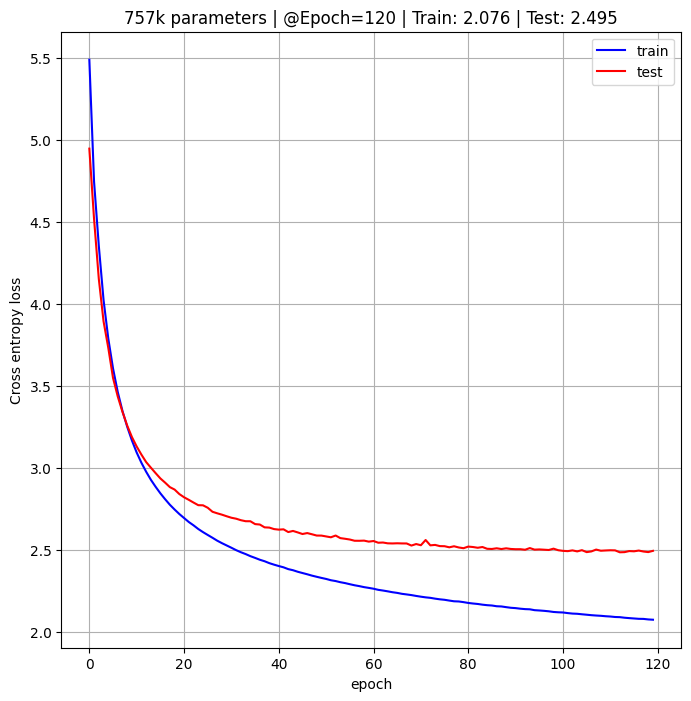

In [17]:
seq2seqModel.load(path_to_save_models/"my_new_model.pt")
number_of_parameters = sum([p.numel() for p in model.parameters()])
metrics = seq2seqModel.get_metrics()

import matplotlib.pyplot as plt
metrics
plt.figure(figsize=(8, 8))
plt.plot(metrics["training_loss"], "b-", label="train")
plt.plot(metrics["test_loss"], "r-", label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Cross entropy loss")
plt.title(f'{round(number_of_parameters/1000)}k parameters | @Epoch={len(metrics["training_loss"])} | Train: {metrics["training_loss"][-1]:.3f} | Test: {metrics["test_loss"][-1]:.3f}')
plt.grid()
plt.show()

## Testing / Task 6:

In [18]:
is_prod = True # production mode or not

# for model_name in ['my_model.pt', 'my_new_model.pt', 'pretrained_moodle.pt']:
for model_name in ['pretrained_moodle.pt']:
    model_path = path_to_save_models / model_name
    assert model_path.exists()
    model = seq2seqModel.load(model_path)
    to_test = ['I am a student.',
            'I have a red car.',  # inversion captured
            'I love playing video games.',
            'This river is full of fish.', # plein vs pleine (accord)
            'The fridge is full of food.',
            'The cat fell asleep on the mat.',
            'my brother likes pizza.', # pizza is translated to 'la pizza'
            'I did not mean to hurt you', # translation of mean in context
            'She is so mean',
            'Help me pick out a tie to go with this suit!', # right translation
            "I can't help but smoking weed", # this one and below: hallucination
            'The kids were playing hide and seek',
            'The cat fell asleep in front of the fireplace']

    print(30*"-" + model_name + 30*"-")
    for elt in to_test:
        print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)))

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
------------------------------pretrained_moodle.pt------------------------------
= = = = = 
 I am a student. -> je suis étudiant . . . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I have a red car. -> j ai une voiture rouge . . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 I love playing video games. -> j adore jouer à jeux jeux jeux vidéo . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 This river is full of fish. -> cette rivière est pleine de poisson . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The fridge is full of food. -> le frigo est plein de nourriture . . . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 The cat fell asleep on the mat. -> le chat s est endormi sur le tapis . . . . . . . . . . . . . . . . . . . . . .
= = = = = 
 my brother likes pizza. -> mon frère aime la pizza . . . . . . . . . . . . . . . . . . . . . . . . .
= = = =

In [85]:
# SAMPLING SEVERAL TEMPERATURES, my pretrained model
for model_name in ['my_new_model.pt']:
    model_path = path_to_save_models / model_name
    assert model_path.exists()
    model = seq2seqModel.load(model_path)
    to_test = ['I love playing video games.', "The kids were playing hide and seek."]
    print(30*"-" + model_name + 30*"-")
    for elt in to_test:
        for temp in [0., 3., 10., 10., 10.]:
            print(f"----- Temperature={temp:.1f}\n{elt}-> {model.predict(elt, temperature=temp)}")

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
------------------------------my_new_model.pt------------------------------


----- Temperature=0.0
I love playing video games.-> j adore jouer aux jeux jeux vidéo . . . vidéo . vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo
----- Temperature=3.0
I love playing video games.-> j adore jouer aux jeux vidéo . vidéo . . vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo demie charbon demie demie faim faim <EOS> faim faim mienne <EOS>
----- Temperature=10.0
I love playing video games.-> j amour jouent aux jeux vidéo . . . . vidéo vidéo vidéo vidéo vidéo ondes faim faim faim faim faim demie <EOS> <EOS> <EOS> <EOS> faim <EOS> vidéo faim
----- Temperature=10.0
I love playing video games.-> j aimes adorent aux jeux . . . . . vidéo . vidéo . . faim faim <EOS> <EOS> vidéo <EOS> <EOS> <EOS> <EOS> <EOS> vidéo <EOS> vidéo vidéo vidéo
----- Temperature=10.0
I love playing video games.-> j aimes à à jeux vidéos . . . . . . ondes vidéo ondes ondes vidéo ondes ondes ondes faim faim faim <EOS> faim faim <EOS> faim fai

In [19]:
for model_name in ['pretrained_moodle.pt']:
    model_path = path_to_save_models / model_name
    assert model_path.exists()
    model = seq2seqModel.load(model_path)
    to_test = [
        "Two women are running in a garden under the rain.",
        "A man is driving a taxi under the rain at night and falls asleep.",
        "She eats a pizza, her friend opens a beer and her baby is sleeping."]

    print(30*"-" + model_name + 30*"-")
    for elt in to_test:
        print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)))

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
------------------------------pretrained_moodle.pt------------------------------
= = = = = 
 Two women are running in a garden under the rain. -> deux femmes femmes sont <OOV> dans la la la pluie . . <EOS>
= = = = = 
 A man is driving a taxi under the rain at night and falls asleep. -> un homme est un taxi taxi sous la pluie la la et et <OOV> . . . . . . . . . . . . . . . .
= = = = = 
 She eats a pizza, her friend opens a beer and her baby is sleeping. -> elle mange une pizza , l son ami de une la et son père père . <EOS>


# Attention visualization (Question 3)

In [20]:
is_prod = True # production mode or not
def visualize_attention(list_of_sentences: List[str], annotation=None, models: List[Path]=['pretrained_moodle.pt']):
    """Code to visualize score maps for a given list of translations"""
    
    for model_name in models:
        model_path = path_to_save_models / model_name
        assert model_path.exists()
        model = seq2seqModel.load(model_path)
        
        for idx, elt in enumerate(list_of_sentences):
            translation =  model.predict(elt, return_list = True)
            cut = len(translation)
            if "." in translation:
                cut = translation.index(".")+1
                translation = translation[:cut]
            translation_str = " ".join(translation)
            # [L, N]
            attn = torch.cat(model.debug_dict["attention"], dim=1).squeeze(0)
            attn = attn.T  # [L_target, L_source].
            attn_cropped =attn[:cut, :len(model.sourceNl_to_ints(elt))]
            attn_cropped = attn_cropped.detach().cpu().numpy()
            print('= = = = = \n','%s -> %s' % (elt, translation_str))
            source_nl_tokens = model.sourceNL_to_tokens(elt)
            plt.figure(figsize=(5, 5))
            plt.imshow(
                attn_cropped,
                cmap="gray"
            )

            plt.xticks(range(len(source_nl_tokens)), source_nl_tokens, rotation=45)
            plt.yticks(range(len(translation)), translation, rotation=45)
            plt.xlabel("source language [english]")
            plt.ylabel("target language [french]")
            if annotation is not None:
                plt.title(annotation[idx])
            plt.show()


## Average examples (not too bad)

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I have a blue car. -> j ai une voiture bleue .


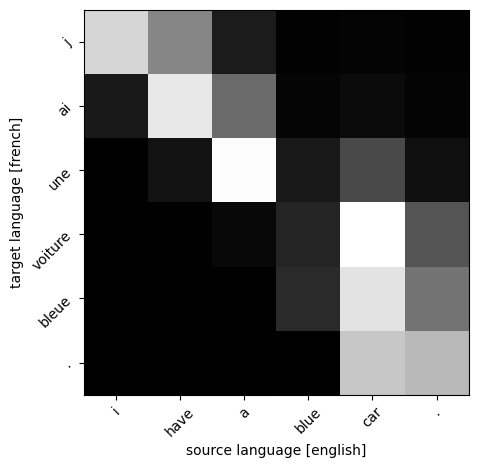

= = = = = 
 Do not open this bottle of red wine. -> n ouvrez pas cette bouteille de vin .


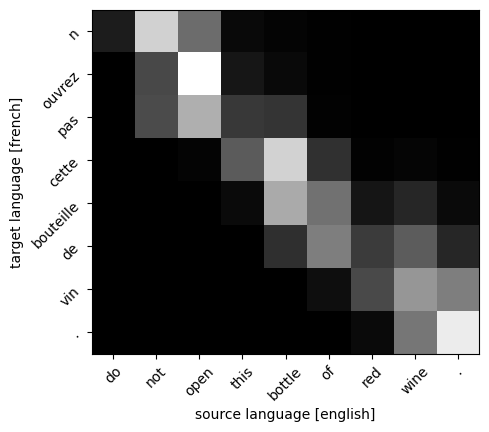

In [21]:
list_of_sentences = ["I have a blue car.", "Do not open this bottle of red wine."]
visualize_attention(list_of_sentences)

## Difficult translation phenomena

max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I have a blue car. -> j ai une voiture bleue .


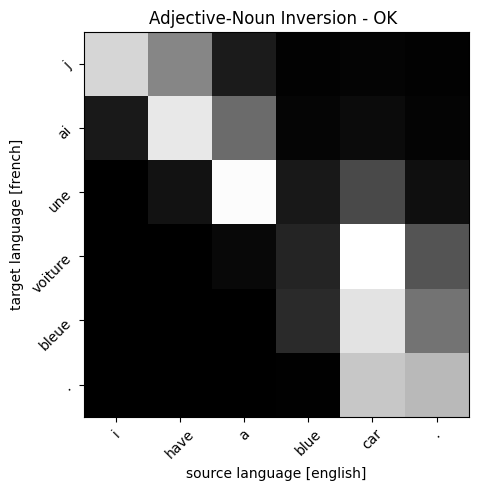

= = = = = 
 Are you coming to the party? -> venez vous à la fête ? ? <EOS>


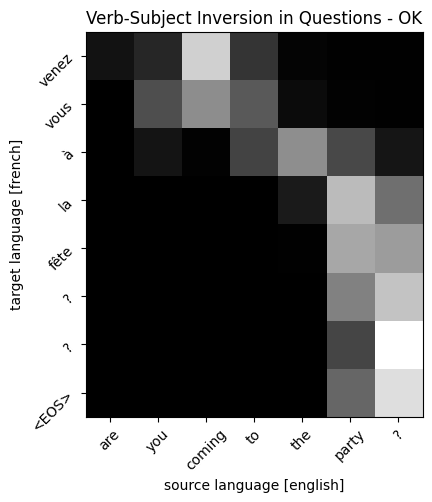

= = = = = 
 I wash my hands before every meal. -> je lave lave mains mains avant .


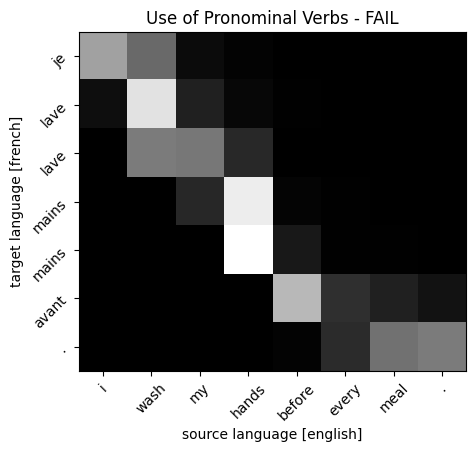

= = = = = 
 She is a talented artist. -> elle est un artiste artiste .


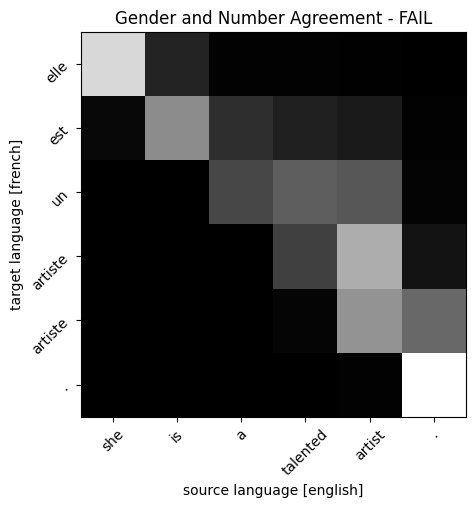

= = = = = 
 It's important that he understands the situation. -> c est important qu il comprend la situation .


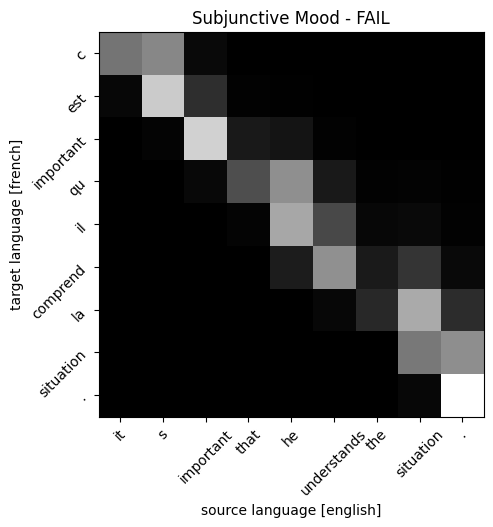

= = = = = 
 I don't know the answer. -> je ne sais pas la réponse .


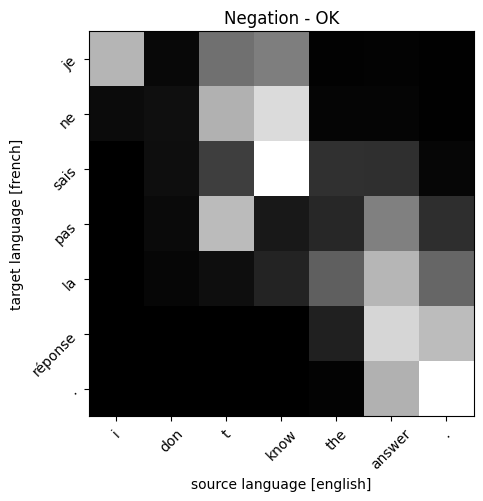

= = = = = 
 I am good at playing the piano. -> je suis bon au jouer piano .


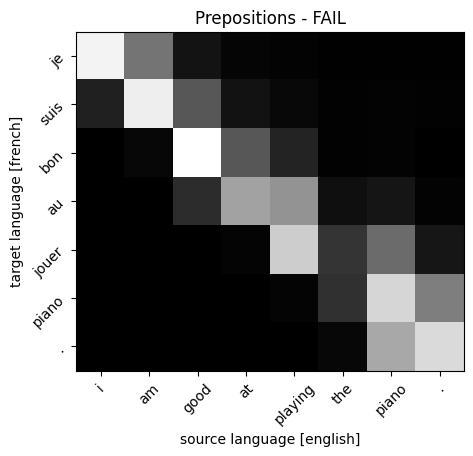

In [22]:
# some examples [ChatGPT4 generated] of difficult translation phenomenon
test_sentences_with_comments = {
    'I have a blue car.': 'Adjective-Noun Inversion - OK ',
    'Are you coming to the party?': 'Verb-Subject Inversion in Questions - OK',
    'I wash my hands before every meal.': 'Use of Pronominal Verbs - FAIL',
    'She is a talented artist.': 'Gender and Number Agreement - FAIL',
    # 'You are my best friend.': 'T-V Distinction',
    "It's important that he understands the situation.": 'Subjunctive Mood - FAIL',
    "I don't know the answer.": 'Negation - OK',
    # 'They often visit their grandparents.': 'Placement of Adverbs',
    # 'The book that you gave me is interesting.': 'Relative Pronouns',
    'I am good at playing the piano.': 'Prepositions - FAIL'
}




visualize_attention(
    list_of_sentences=list(test_sentences_with_comments.keys()),
    annotation=[phenomenon for _, phenomenon in test_sentences_with_comments.items()]
)

# test_sentences_with_comments_TV = {
#     'You are my best friend.': 'T-V Distinction',
#     'you are a nice person Sir.': 'T-V Distinction FAIL',
#     'you look nice today madam.': 'T-V Distinction FAIL',
#     # 'Sir, do you want me to bring your suitcase to your room?': 'T-V Distinction',
# }

In [ ]:
# list_of_sentences = ["You have a blue car.", "You have a tiny car." , "a little car.", "this is a blue car."]
# list_of_sentences = ["I have a red car."]
# list_of_sentences = ["I have blue eyes."]
# list_of_sentences =  ["My eyes are not blue."]
# list_of_sentences = ["I have a green nose."]
# list_of_sentences = ["I have a black dog ."]
# list_of_sentences = ["I saw two black dogs."]
# list_of_sentences = ['my brother likes pizza.', "my sister does not like pizza."]
# list_of_sentences = ["two black dogs in front of my house."]
# list_of_sentences = ["three people are standing in front of my house."]
# visualize_attention(["You have beautiful brown hair.", "I have blue eyes.", "Your eyes are light blue."])
# visualize_attention(["The sky is light blue.", "Her eyes are light blue."])